Import necessary libraries

In [61]:
import os
import json
from ultralytics import YOLO
import matplotlib.pyplot as plt
import albumentations as A
from torch.utils.data import Dataset
import torch

Verify Paths

In [62]:
# Define base path
base_path = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/yolov8'

# Check directory paths
train_images = os.path.join(base_path, 'train/images')
valid_images = os.path.join(base_path, 'valid/images')
train_labels = os.path.join(base_path, 'train/labels')
valid_labels = os.path.join(base_path, 'valid/labels')

print(f"Train images directory exists: {os.path.exists(train_images)}")
print(f"Valid images directory exists: {os.path.exists(valid_images)}")
print(f"Train labels directory exists: {os.path.exists(train_labels)}")
print(f"Valid labels directory exists: {os.path.exists(valid_labels)}")

# Check for image files in train/images and valid/images
train_image_files = os.listdir(train_images)
valid_image_files = os.listdir(valid_images)
print(f"Number of images in train/images: {len(train_image_files)}")
print(f"Number of images in valid/images: {len(valid_image_files)}")
print(f"Sample image file in train/images: {train_image_files[0] if train_image_files else 'No images found'}")
print(f"Sample image file in valid/images: {valid_image_files[0] if valid_image_files else 'No images found'}")

# Check for label files in train/labels and valid/labels
train_label_files = os.listdir(train_labels)
valid_label_files = os.listdir(valid_labels)
print(f"Number of labels in train/labels: {len(train_label_files)}")
print(f"Number of labels in valid/labels: {len(valid_label_files)}")
print(f"Sample label file in train/labels: {train_label_files[0] if train_label_files else 'No labels found'}")
print(f"Sample label file in valid/labels: {valid_label_files[0] if valid_label_files else 'No labels found'}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Train images directory exists: True
Valid images directory exists: True
Train labels directory exists: True
Valid labels directory exists: True
Number of images in train/images: 1080
Number of images in valid/images: 120
Sample image file in train/images: 0AuZ8iMUdcKOVqLFwI4467e4smSjGllWkACcq7jV.jpeg
Sample image file in valid/images: 0x9j1Zep8zFHm1ABz45GgLWqzIZ9JjOHgXFQlc25.jpeg
Number of labels in train/labels: 1080
Number of labels in valid/labels: 120
Sample label file in train/labels: 0AuZ8iMUdcKOVqLFwI4467e4smSjGllWkACcq7jV.txt
Sample label file in valid/labels: 0x9j1Zep8zFHm1ABz45GgLWqzIZ9JjOHgXFQlc25.txt
Using device: cpu


Number and name of classes

In [36]:
import json
import os

def extract_classes(annotations_file):
    with open(annotations_file, 'r') as f:
        data = json.load(f)

    categories = data['categories']
    class_names = [category['name'] for category in categories]
    num_classes = len(class_names)

    return num_classes, class_names

annotations_file = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/annotations.json'
num_classes, class_names = extract_classes(annotations_file)

print(f'Number of classes: {num_classes}')
print('Class names:')
for i, name in enumerate(class_names):
    print(f'{i + 1}. {name}')




Number of classes: 60
Class names:
1. Aluminium foil
2. Battery
3. Aluminium blister pack
4. Carded blister pack
5. Other plastic bottle
6. Clear plastic bottle
7. Glass bottle
8. Plastic bottle cap
9. Metal bottle cap
10. Broken glass
11. Food Can
12. Aerosol
13. Drink can
14. Toilet tube
15. Other carton
16. Egg carton
17. Drink carton
18. Corrugated carton
19. Meal carton
20. Pizza box
21. Paper cup
22. Disposable plastic cup
23. Foam cup
24. Glass cup
25. Other plastic cup
26. Food waste
27. Glass jar
28. Plastic lid
29. Metal lid
30. Other plastic
31. Magazine paper
32. Tissues
33. Wrapping paper
34. Normal paper
35. Paper bag
36. Plastified paper bag
37. Plastic film
38. Six pack rings
39. Garbage bag
40. Other plastic wrapper
41. Single-use carrier bag
42. Polypropylene bag
43. Crisp packet
44. Spread tub
45. Tupperware
46. Disposable food container
47. Foam food container
48. Other plastic container
49. Plastic glooves
50. Plastic utensils
51. Pop tab
52. Rope & strings
53. Scr

Set up paths and parameters

In [37]:
train_images = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/yolov8/train/images'
train_labels = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/yolov8/train/labels'
valid_images = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/yolov8/valid/images'
valid_labels = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/yolov8/valid/labels'

# Define broad categories
broad_categories = {
    'plastic': ['Other plastic bottle', 'Clear plastic bottle', 'Plastic bottle cap', 'Plastic lid', 'Other plastic', 'Plastic film', 'Six pack rings', 'Garbage bag', 'Other plastic wrapper', 'Single-use carrier bag', 'Polypropylene bag', 'Crisp packet', 'Spread tub', 'Tupperware', 'Disposable food container', 'Other plastic container', 'Plastic gloves', 'Plastic utensils', 'Squeezable tube', 'Plastic straw', 'Styrofoam piece'],
    'metal': ['Aluminium foil', 'Battery', 'Aluminium blister pack', 'Carded blister pack', 'Metal bottle cap', 'Food Can', 'Aerosol', 'Drink can', 'Metal lid', 'Scrap metal', 'Pop tab'],
    'glass': ['Glass bottle', 'Broken glass', 'Glass cup', 'Glass jar'],
    'paper': ['Pizza box', 'Paper cup', 'Magazine paper', 'Tissues', 'Wrapping paper', 'Normal paper', 'Paper bag', 'Plastified paper bag', 'Corrugated carton', 'Meal carton', 'Drink carton', 'Egg carton', 'Other carton', 'Toilet tube'],
    'other': ['Food waste', 'Unlabeled litter', 'Cigarette', 'Shoe', 'Rope & strings']
}

# Create the updated names list with broader categories
updated_names = list(broad_categories.keys())
nc = len(updated_names)

data_yaml = f"""
path: C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/yolov8
train: train/images
val: valid/images
nc: {nc}
names: {updated_names}
"""

# Write the updated YAML configuration to a file
with open('C:/Users/Nicho/Desktop/Thesis/yodaTaco2/custom_data.yaml', 'w') as f:
    f.write(data_yaml)


Update Labels to Broad Categories


In [38]:
# Function to remap labels
def remap_labels(label_file, class_mapping):
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        
        # Find the new class id
        new_class_id = None
        for i, (broad_class, specific_classes) in enumerate(class_mapping.items()):
            if class_names[class_id] in specific_classes:
                new_class_id = i
                break
        
        if new_class_id is not None:
            parts[0] = str(new_class_id)
            new_lines.append(" ".join(parts))
    
    with open(label_file, 'w') as f:
        f.write("\n".join(new_lines))

# Update train labels
for label_file in os.listdir(train_labels):
    remap_labels(os.path.join(train_labels, label_file), broad_categories)

# Update valid labels
for label_file in os.listdir(valid_labels):
    remap_labels(os.path.join(valid_labels, label_file), broad_categories)


Custom Dataset with Data Augmentation

In [44]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images_path = images_path
        self.labels_path = labels_path
        self.transform = transform
        self.images = os.listdir(images_path)
        self.labels = os.listdir(labels_path)

    def __getitem__(self, index):
        # Load image and label
        image_path = os.path.join(self.images_path, self.images[index])
        label_path = os.path.join(self.labels_path, self.labels[index])
        
        # Use PIL to read the image to handle various formats
        image = Image.open(image_path).convert('RGB')
        image = np.array(image)
        
        label = self.load_label(label_path)
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

    def __len__(self):
        return len(self.images)

    def load_label(self, label_path):
        with open(label_path, 'r') as f:
            labels = f.readlines()
        return [list(map(float, label.strip().split())) for label in labels]

# Define augmentations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.2),
    A.Blur(p=0.1),
])

# Create datasets
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
valid_dataset = CustomDataset(valid_images, valid_labels)


Verify Data Loading and Augmentation

In [45]:
import matplotlib.pyplot as plt

# visualize dataset samples
def visualize_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, label = dataset[i]
        plt.imshow(image)
        plt.title(f'Label: {label}')
        plt.show()

# Visualize training samples with augmentation
print("Training Samples with Augmentation:")
visualize_samples(train_dataset)

# Visualize validation samples without augmentation
print("Validation Samples without Augmentation:")
visualize_samples(valid_dataset)


Training Samples with Augmentation:


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Validation Samples without Augmentation:


<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

Verify the Custom Dataset Class

In [46]:
# Check a few samples from the custom dataset
for i in range(3):
    img, label = train_dataset[i]
    print(f"Image {i} shape: {img.shape}, Label: {label}")

# Check a few samples from the validation dataset
for i in range(3):
    img, label = valid_dataset[i]
    print(f"Image {i} shape: {img.shape}, Label: {label}")


Image 0 shape: (3024, 4032, 3), Label: [[0.0, 0.44345238095238093, 0.22854662698412698, 0.419973544973545, 0.21999007936507936], [3.0, 0.43287037037037035, 0.38492063492063494, 0.08796296296296297, 0.08779761904761904], [0.0, 0.4718915343915344, 0.7084573412698413, 0.2156084656084656, 0.1515376984126984], [0.0, 0.35830026455026454, 0.8849206349206349, 0.08763227513227513, 0.15773809523809523], [0.0, 0.2361111111111111, 0.8843005952380952, 0.15806878306878308, 0.13467261904761904]]
Image 1 shape: (4160, 3120, 3), Label: [[0.0, 0.7724358974358975, 0.715625, 0.1544871794871795, 0.18221153846153845], [0.0, 0.353125, 0.48203125, 0.39791666666666664, 0.2984375]]
Image 2 shape: (4160, 3120, 3), Label: [[0.0, 0.5157051282051283, 0.37127403846153845, 0.26282051282051283, 0.4266826923076923], [0.0, 0.46089743589743587, 0.20540865384615384, 0.1391025641025641, 0.09447115384615384]]
Image 0 shape: (4160, 3120, 3), Label: [[0.0, 0.4032051282051282, 0.6165865384615384, 0.8057692307692308, 0.76634615

Verify Data Augmentation

In [47]:
# Function to visualize before and after augmentation
def visualize_augmentation(dataset, index=0):
    image, _ = dataset[index]
    augmented = transform(image=image)
    augmented_image = augmented['image']
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[1].imshow(augmented_image)
    axes[1].set_title('Augmented Image')
    plt.show()

# Visualize augmentation
visualize_augmentation(train_dataset, index=0)


<Figure size 1200x600 with 2 Axes>

Placeholder for Metrics Initialization

In [72]:
# Placeholder for metrics
accuracy_over_epochs = []
f1_score_over_epochs = []
precision_over_epochs = []
recall_over_epochs = []
confusion_matrix = None

# metric initialization
metrics = {
    'accuracy': accuracy_over_epochs,
    'f1_score': f1_score_over_epochs,
    'precision': precision_over_epochs,
    'recall': recall_over_epochs,
    'confusion_matrix': confusion_matrix
}

print("Metrics initialized:", metrics)


Metrics initialized: {'accuracy': [], 'f1_score': [], 'precision': [], 'recall': [], 'confusion_matrix': None}


Initialize the YOLOv8 model

In [51]:
model = YOLO('yolov8s.pt')

Train the model

In [52]:
# Train the model and save metrics
results = model.train(data='C:/Users/Nicho/Desktop/Thesis/yodaTaco2/custom_data.yaml', epochs=1, imgsz=640, batch=16)

# Save the trained model
model.save('C:/Users/Nicho/Desktop/Thesis/yodaTaco2/trained_model.pt')

Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 9 7950X 16-Core Processor)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/Nicho/Desktop/Thesis/yodaTaco2/custom_data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

train: Scanning C:\Users\Nicho\Desktop\Thesis\yodaTaco2\litter-detection-env\yolov8\train\labels... 1080 images, 38 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<00:00, 2790.21it/s]

train: New cache created: C:\Users\Nicho\Desktop\Thesis\yodaTaco2\litter-detection-env\yolov8\train\labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\Nicho\Desktop\Thesis\yodaTaco2\litter-detection-env\yolov8\valid\labels... 120 images, 6 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<00:00, 2767.47it/s]

val: New cache created: C:\Users\Nicho\Desktop\Thesis\yodaTaco2\litter-detection-env\yolov8\valid\labels.cache
Plotting labels to runs\detect\train6\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train6
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1         0G      1.172      2.923      1.177         22        640: 100%|██████████| 68/68 [22:11<00:00, 19.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.22s/it]


                   all        120        335      0.357      0.174     0.0944     0.0634

1 epochs completed in 0.386 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 22.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 9 7950X 16-Core Processor)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:49<00:00, 12.45s/it]


                   all        120        335      0.357      0.174     0.0948     0.0634
               plastic         90        227      0.285      0.278      0.166     0.0961
                 metal         21         53      0.205       0.34      0.161      0.108
                 glass          6         10     0.0877        0.1     0.0242     0.0158
                 paper         26         39      0.209      0.154      0.119     0.0955
                 other          6          6          1          0    0.00327    0.00125
Speed: 3.2ms preprocess, 341.2ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs\detect\train6


Visualization

Extract and Save Metrics

In [73]:
import os
import pickle
from ultralytics import YOLO

# Initialize and train the model
model = YOLO('yolov8s.pt')
results = model.train(data='C:/Users/Nicho/Desktop/Thesis/yodaTaco2/custom_data.yaml', epochs=75, imgsz=640, batch=16, device='cpu')
model.save('C:/Users/Nicho/Desktop/Thesis/yodaTaco2/trained_model.pt')



if hasattr(results, 'results_dict'):
    metrics = results.results_dict

    # Extract metrics
    accuracy_over_epochs = metrics['metrics/precision'] if 'metrics/precision' in metrics else None
    f1_score_over_epochs = metrics['metrics/f1'] if 'metrics/f1' in metrics else None
    precision_over_epochs = metrics['metrics/precision'] if 'metrics/precision' in metrics else None
    recall_over_epochs = metrics['metrics/recall'] if 'metrics/recall' in metrics else None

    # Save metrics
    metrics_dict = {
        'accuracy': accuracy_over_epochs,
        'f1_score': f1_score_over_epochs,
        'precision': precision_over_epochs,
        'recall': recall_over_epochs
    }

    with open('C:/Users/Nicho/Desktop/Thesis/yodaTaco2/training_metrics.pkl', 'wb') as f:
        pickle.dump(metrics_dict, f)

    print("Training and metrics saving completed.")
else:
    print("No results_dict attribute found in results.")


Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 9 7950X 16-Core Processor)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:/Users/Nicho/Desktop/Thesis/yodaTaco2/custom_data.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False,

train: Scanning C:\Users\Nicho\Desktop\Thesis\yodaTaco2\litter-detection-env\yolov8\train\labels.cache... 1080 images, 38 backgrounds, 0 corrupt: 100%|██████████| 1080/1080 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\Nicho\Desktop\Thesis\yodaTaco2\litter-detection-env\yolov8\valid\labels.cache... 120 images, 6 backgrounds, 0 corrupt: 100%|██████████| 120/120 [00:00<?, ?it/s]

Plotting labels to runs\detect\train9\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train9
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75         0G      1.172      2.923      1.177         22        640: 100%|██████████| 68/68 [21:25<00:00, 18.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.74s/it]

                   all        120        335      0.357      0.174     0.0944     0.0634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75         0G      1.268      2.219      1.226         33        640: 100%|██████████| 68/68 [21:18<00:00, 18.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.69s/it]

                   all        120        335      0.304      0.128      0.054      0.028



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75         0G       1.34       2.22      1.285         47        640: 100%|██████████| 68/68 [21:15<00:00, 18.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.98s/it]

                   all        120        335      0.521     0.0928     0.0614     0.0354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75         0G      1.389      2.258      1.292         49        640: 100%|██████████| 68/68 [21:19<00:00, 18.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.68s/it]

                   all        120        335      0.328      0.178      0.104     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75         0G      1.356      2.155       1.26         52        640: 100%|██████████| 68/68 [21:20<00:00, 18.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.82s/it]

                   all        120        335       0.53      0.172      0.111     0.0623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75         0G       1.33      2.129      1.259         51        640: 100%|██████████| 68/68 [21:13<00:00, 18.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.83s/it]

                   all        120        335      0.296      0.214      0.108     0.0627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75         0G      1.305      2.068      1.236         27        640: 100%|██████████| 68/68 [21:21<00:00, 18.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.75s/it]

                   all        120        335       0.56      0.167      0.112      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75         0G      1.272      2.031      1.222         54        640: 100%|██████████| 68/68 [21:12<00:00, 18.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.70s/it]

                   all        120        335      0.646      0.155      0.169      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75         0G      1.251      1.963      1.201         26        640: 100%|██████████| 68/68 [21:22<00:00, 18.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.71s/it]

                   all        120        335      0.382      0.177      0.149     0.0995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75         0G       1.22      1.897      1.196         45        640: 100%|██████████| 68/68 [21:22<00:00, 18.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.81s/it]

                   all        120        335       0.36      0.277      0.152      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75         0G      1.222      1.883      1.189         63        640: 100%|██████████| 68/68 [21:13<00:00, 18.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.66s/it]

                   all        120        335      0.358      0.218      0.146     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75         0G      1.193      1.836      1.167         32        640: 100%|██████████| 68/68 [21:19<00:00, 18.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.81s/it]

                   all        120        335      0.591        0.2      0.177      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75         0G       1.17       1.76       1.16         27        640: 100%|██████████| 68/68 [21:10<00:00, 18.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.68s/it]

                   all        120        335      0.627      0.222      0.177      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75         0G      1.156      1.768      1.159         22        640: 100%|██████████| 68/68 [21:18<00:00, 18.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.70s/it]

                   all        120        335      0.593      0.193      0.212      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75         0G      1.128      1.741      1.134         40        640: 100%|██████████| 68/68 [21:19<00:00, 18.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.71s/it]

                   all        120        335      0.397      0.211      0.163      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75         0G      1.118      1.755      1.148         25        640: 100%|██████████| 68/68 [21:21<00:00, 18.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.72s/it]

                   all        120        335      0.378        0.3      0.176      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75         0G      1.121      1.674       1.14         74        640: 100%|██████████| 68/68 [21:22<00:00, 18.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.79s/it]

                   all        120        335      0.394      0.192      0.155     0.0977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75         0G      1.113      1.675      1.146         27        640: 100%|██████████| 68/68 [21:13<00:00, 18.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.69s/it]

                   all        120        335      0.384      0.327      0.189      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75         0G      1.081      1.604      1.111         29        640: 100%|██████████| 68/68 [21:22<00:00, 18.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.69s/it]

                   all        120        335      0.449      0.255      0.169      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75         0G      1.068      1.563      1.105         40        640: 100%|██████████| 68/68 [21:18<00:00, 18.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.87s/it]

                   all        120        335      0.397      0.257      0.178      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75         0G      1.044      1.531      1.102         34        640: 100%|██████████| 68/68 [21:13<00:00, 18.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.75s/it]

                   all        120        335      0.521      0.219      0.193      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75         0G      1.048      1.544      1.097         13        640: 100%|██████████| 68/68 [21:18<00:00, 18.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.71s/it]

                   all        120        335      0.601      0.245      0.216      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75         0G      1.028       1.52       1.09         46        640: 100%|██████████| 68/68 [21:20<00:00, 18.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.76s/it]

                   all        120        335      0.418      0.225      0.183      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75         0G      1.036      1.453      1.092         38        640: 100%|██████████| 68/68 [21:13<00:00, 18.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.72s/it]

                   all        120        335      0.561      0.204      0.201      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75         0G      1.049      1.487      1.104         46        640: 100%|██████████| 68/68 [21:19<00:00, 18.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.72s/it]

                   all        120        335      0.454      0.206      0.183       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75         0G     0.9982      1.433      1.075         42        640: 100%|██████████| 68/68 [21:22<00:00, 18.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.78s/it]

                   all        120        335      0.452      0.212      0.191      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75         0G      1.018      1.408      1.082         28        640: 100%|██████████| 68/68 [21:32<00:00, 19.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.86s/it]

                   all        120        335      0.452      0.219      0.187      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75         0G     0.9836      1.352      1.068         36        640: 100%|██████████| 68/68 [21:43<00:00, 19.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.03s/it]

                   all        120        335      0.372      0.216       0.19      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75         0G     0.9888      1.407      1.062         38        640: 100%|██████████| 68/68 [21:49<00:00, 19.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.90s/it]

                   all        120        335      0.497      0.223      0.189      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75         0G     0.9759      1.373      1.062         55        640: 100%|██████████| 68/68 [21:46<00:00, 19.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.94s/it]

                   all        120        335      0.213      0.256      0.167      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75         0G     0.9652      1.289      1.051         47        640: 100%|██████████| 68/68 [21:39<00:00, 19.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.98s/it]

                   all        120        335      0.445      0.224      0.185       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75         0G     0.9694      1.278      1.047         20        640: 100%|██████████| 68/68 [22:10<00:00, 19.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.13s/it]

                   all        120        335      0.209      0.275      0.191      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75         0G     0.9337      1.224      1.032         21        640: 100%|██████████| 68/68 [21:47<00:00, 19.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.03s/it]

                   all        120        335      0.234      0.199      0.182       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75         0G     0.9352       1.25      1.053         30        640: 100%|██████████| 68/68 [21:45<00:00, 19.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.06s/it]

                   all        120        335      0.558       0.22      0.211      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75         0G     0.9489      1.196      1.032         45        640: 100%|██████████| 68/68 [21:42<00:00, 19.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.12s/it]

                   all        120        335      0.329      0.281      0.212      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75         0G     0.9136      1.163      1.022         37        640: 100%|██████████| 68/68 [21:57<00:00, 19.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.93s/it]

                   all        120        335      0.253      0.216        0.2      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75         0G     0.9209      1.176      1.037         26        640: 100%|██████████| 68/68 [21:57<00:00, 19.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.12s/it]

                   all        120        335      0.535      0.206      0.188      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75         0G     0.9337       1.16      1.028         23        640: 100%|██████████| 68/68 [21:43<00:00, 19.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<00:00, 14.38s/it]

                   all        120        335      0.589      0.193      0.202      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75         0G     0.8735      1.104      1.011         29        640: 100%|██████████| 68/68 [22:08<00:00, 19.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.07s/it]

                   all        120        335      0.174      0.258      0.161      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75         0G     0.8817      1.067      1.013         40        640: 100%|██████████| 68/68 [21:51<00:00, 19.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.95s/it]

                   all        120        335      0.293      0.237      0.202      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75         0G     0.8749      1.042      1.017         49        640: 100%|██████████| 68/68 [21:16<00:00, 18.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.67s/it]

                   all        120        335      0.453      0.231      0.229      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75         0G     0.8753      1.045      1.012         25        640: 100%|██████████| 68/68 [21:31<00:00, 18.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.89s/it]

                   all        120        335      0.289      0.276      0.205       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75         0G     0.8844      1.065      1.011         22        640: 100%|██████████| 68/68 [21:33<00:00, 19.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.70s/it]

                   all        120        335      0.526      0.236      0.208      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75         0G     0.8534     0.9647     0.9845         34        640: 100%|██████████| 68/68 [21:17<00:00, 18.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.63s/it]

                   all        120        335      0.355      0.229      0.225      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75         0G     0.8555     0.9846      1.003         37        640: 100%|██████████| 68/68 [21:40<00:00, 19.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.07s/it]

                   all        120        335      0.336      0.216      0.216      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75         0G     0.8349     0.9351     0.9889        149        640: 100%|██████████| 68/68 [21:53<00:00, 19.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<00:00, 14.28s/it]

                   all        120        335      0.341      0.232      0.201      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75         0G     0.8627      0.949     0.9944         67        640: 100%|██████████| 68/68 [21:45<00:00, 19.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.04s/it]

                   all        120        335      0.326      0.235       0.22      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75         0G     0.8423     0.9435      0.987         30        640: 100%|██████████| 68/68 [21:49<00:00, 19.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.81s/it]

                   all        120        335      0.575      0.236      0.221      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75         0G     0.8259     0.9001     0.9817         40        640: 100%|██████████| 68/68 [21:46<00:00, 19.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.87s/it]

                   all        120        335      0.326      0.225      0.206      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75         0G     0.8217     0.8849     0.9828         61        640: 100%|██████████| 68/68 [21:30<00:00, 18.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:54<00:00, 13.69s/it]

                   all        120        335      0.624      0.184      0.209      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75         0G     0.8279     0.8676      0.988         31        640: 100%|██████████| 68/68 [21:53<00:00, 19.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.06s/it]

                   all        120        335      0.582      0.201      0.196      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75         0G     0.8211     0.8624     0.9779         35        640: 100%|██████████| 68/68 [21:57<00:00, 19.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.21s/it]

                   all        120        335      0.557       0.22      0.197      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75         0G     0.8089     0.8399     0.9746         33        640: 100%|██████████| 68/68 [22:16<00:00, 19.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.17s/it]

                   all        120        335      0.592      0.179      0.198       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75         0G     0.8282     0.8399     0.9791         46        640: 100%|██████████| 68/68 [22:13<00:00, 19.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.06s/it]

                   all        120        335      0.334      0.242      0.201       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75         0G     0.7733     0.7859     0.9621         29        640: 100%|██████████| 68/68 [22:02<00:00, 19.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.00s/it]

                   all        120        335      0.607      0.199      0.198      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75         0G     0.7729     0.7802     0.9581         32        640: 100%|██████████| 68/68 [21:57<00:00, 19.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<00:00, 14.26s/it]

                   all        120        335      0.601      0.235       0.21      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75         0G     0.8046     0.7846     0.9673         31        640: 100%|██████████| 68/68 [21:58<00:00, 19.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.04s/it]

                   all        120        335      0.323      0.241      0.229      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75         0G     0.7664     0.7441     0.9583         41        640: 100%|██████████| 68/68 [22:48<00:00, 20.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.92s/it]

                   all        120        335       0.61      0.203      0.206      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75         0G     0.7541     0.7231     0.9505         19        640: 100%|██████████| 68/68 [22:14<00:00, 19.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:55<00:00, 13.96s/it]

                   all        120        335      0.561      0.229        0.2      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75         0G     0.7682     0.7164     0.9549         18        640: 100%|██████████| 68/68 [21:55<00:00, 19.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.08s/it]

                   all        120        335      0.424        0.2      0.209      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75         0G     0.7476     0.7083     0.9438         56        640: 100%|██████████| 68/68 [22:05<00:00, 19.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.15s/it]

                   all        120        335      0.402      0.201      0.191      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75         0G     0.7401      0.709     0.9412         33        640: 100%|██████████| 68/68 [22:07<00:00, 19.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.17s/it]

                   all        120        335        0.6      0.192      0.183      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75         0G     0.7585     0.7066     0.9527         25        640: 100%|██████████| 68/68 [22:28<00:00, 19.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.14s/it]

                   all        120        335       0.56      0.199        0.2      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75         0G     0.7277     0.6594     0.9388         24        640: 100%|██████████| 68/68 [22:22<00:00, 19.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.13s/it]

                   all        120        335      0.674      0.188      0.212      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75         0G     0.7411     0.6744     0.9361         40        640: 100%|██████████| 68/68 [22:22<00:00, 19.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.11s/it]

                   all        120        335      0.381      0.231       0.21      0.157


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75         0G     0.6715     0.6216     0.9014         15        640: 100%|██████████| 68/68 [22:02<00:00, 19.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.18s/it]

                   all        120        335      0.362      0.211       0.19      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75         0G     0.6672     0.5832     0.8953         19        640: 100%|██████████| 68/68 [22:04<00:00, 19.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.22s/it]

                   all        120        335      0.417      0.213      0.205      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75         0G     0.6415     0.5655     0.8811         14        640: 100%|██████████| 68/68 [22:09<00:00, 19.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.19s/it]

                   all        120        335      0.307      0.235      0.209      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75         0G     0.6462     0.5555     0.8868         54        640: 100%|██████████| 68/68 [22:12<00:00, 19.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<00:00, 14.41s/it]

                   all        120        335       0.62      0.214      0.208      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75         0G     0.6549     0.5412     0.8768         66        640: 100%|██████████| 68/68 [22:13<00:00, 19.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.21s/it]

                   all        120        335      0.332      0.235      0.205      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75         0G     0.6369     0.5261     0.8819         13        640: 100%|██████████| 68/68 [22:09<00:00, 19.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.09s/it]

                   all        120        335      0.316      0.219      0.191      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75         0G     0.6033     0.4925     0.8657         11        640: 100%|██████████| 68/68 [21:59<00:00, 19.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.12s/it]

                   all        120        335      0.603      0.213      0.203      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75         0G     0.6286     0.5035      0.873         18        640: 100%|██████████| 68/68 [21:55<00:00, 19.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:57<00:00, 14.35s/it]

                   all        120        335      0.302      0.319      0.217       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75         0G     0.6231     0.5141     0.8801         42        640: 100%|██████████| 68/68 [21:50<00:00, 19.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.06s/it]

                   all        120        335      0.311      0.285      0.216      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75         0G      0.615      0.492     0.8708         16        640: 100%|██████████| 68/68 [21:56<00:00, 19.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:56<00:00, 14.02s/it]

                   all        120        335      0.324      0.279      0.221      0.164



75 epochs completed in 28.336 hours.
Optimizer stripped from runs\detect\train9\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train9\weights\best.pt, 22.5MB

Validating runs\detect\train9\weights\best.pt...
Ultralytics YOLOv8.2.28  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 9 7950X 16-Core Processor)
Model summary (fused): 168 layers, 11127519 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:50<00:00, 12.53s/it]


                   all        120        335      0.323      0.241      0.229      0.176
               plastic         90        227      0.455      0.401      0.336      0.216
                 metal         21         53      0.553      0.396      0.409       0.33
                 glass          6         10      0.182        0.1      0.103     0.0799
                 paper         26         39      0.426      0.308      0.299      0.251
                 other          6          6          0          0          0          0
Speed: 2.6ms preprocess, 344.6ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs\detect\train9
Training and metrics saving completed.


Metrics

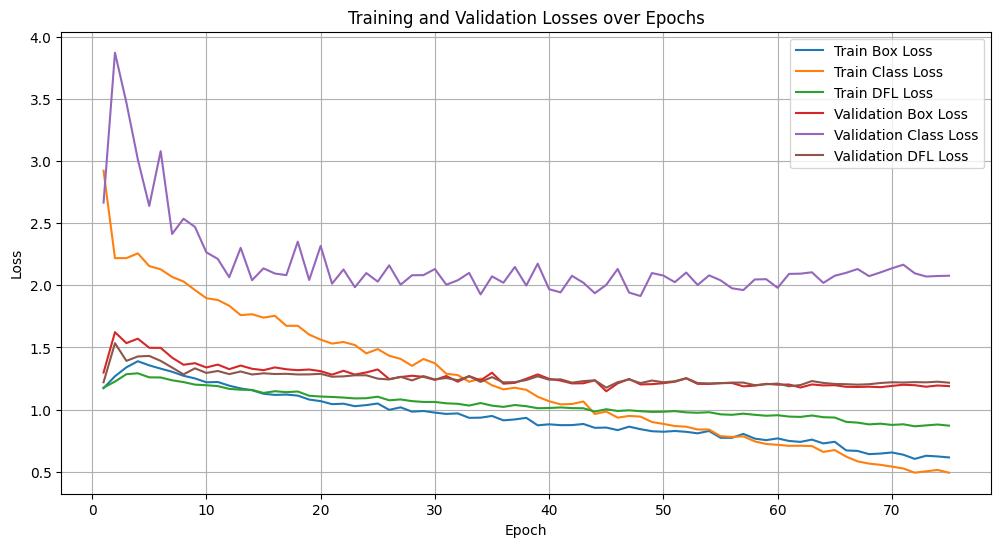

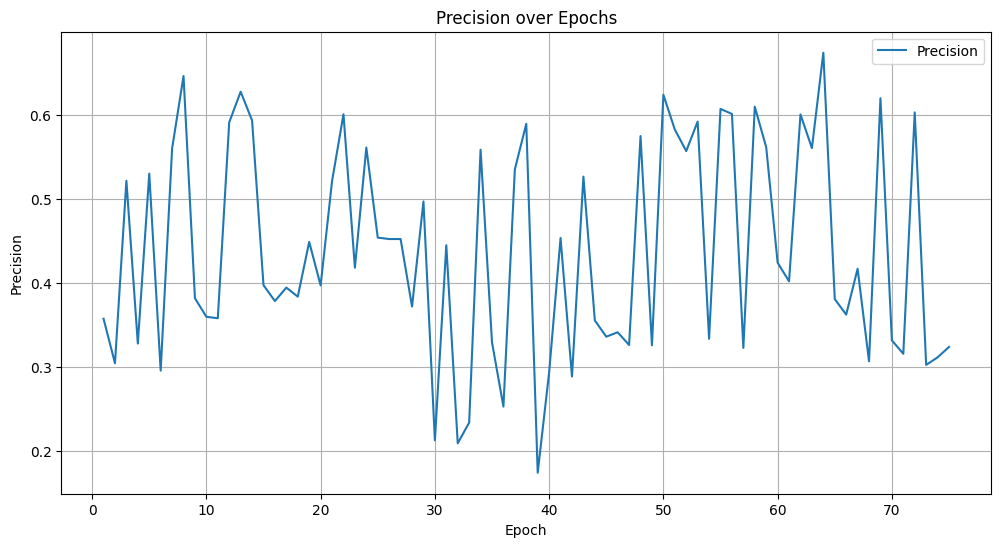

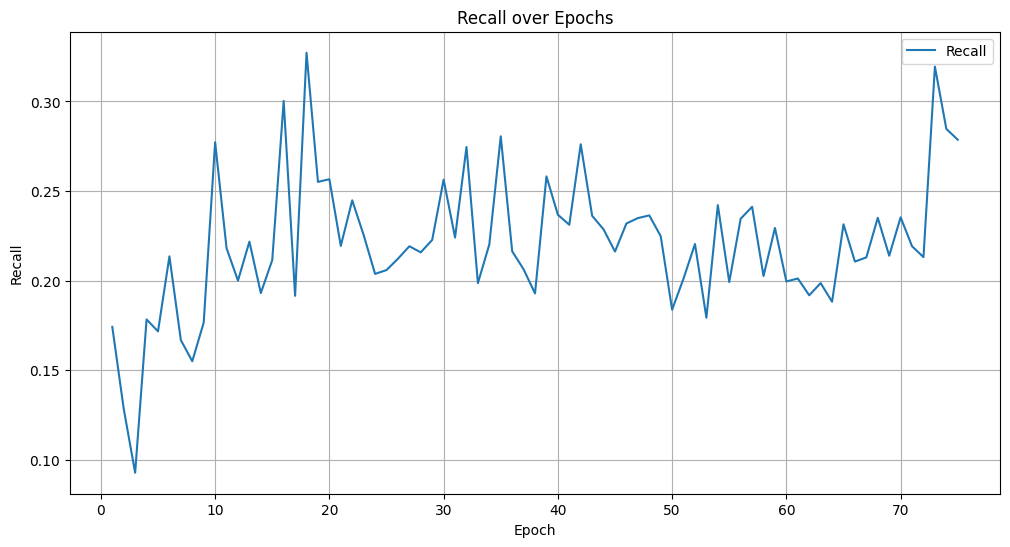

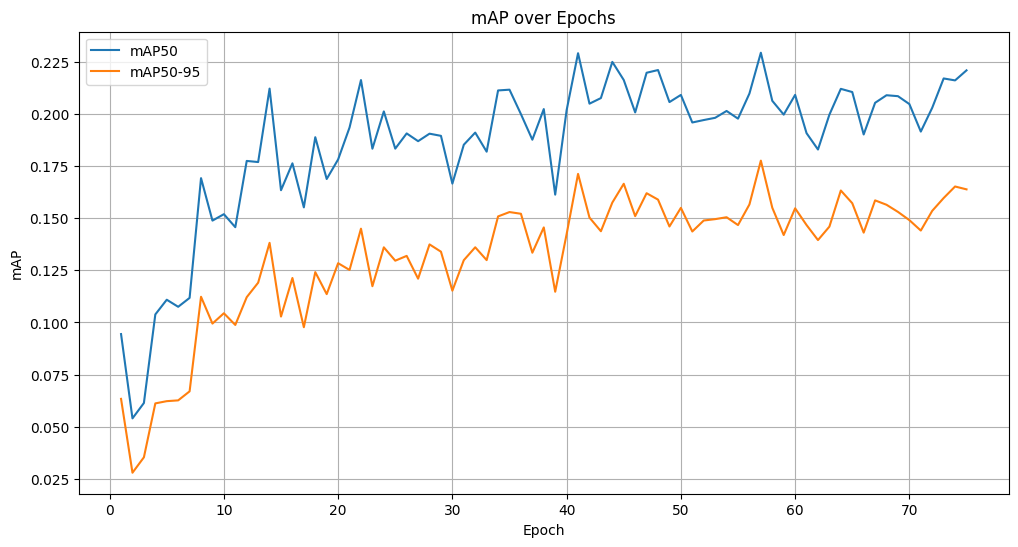

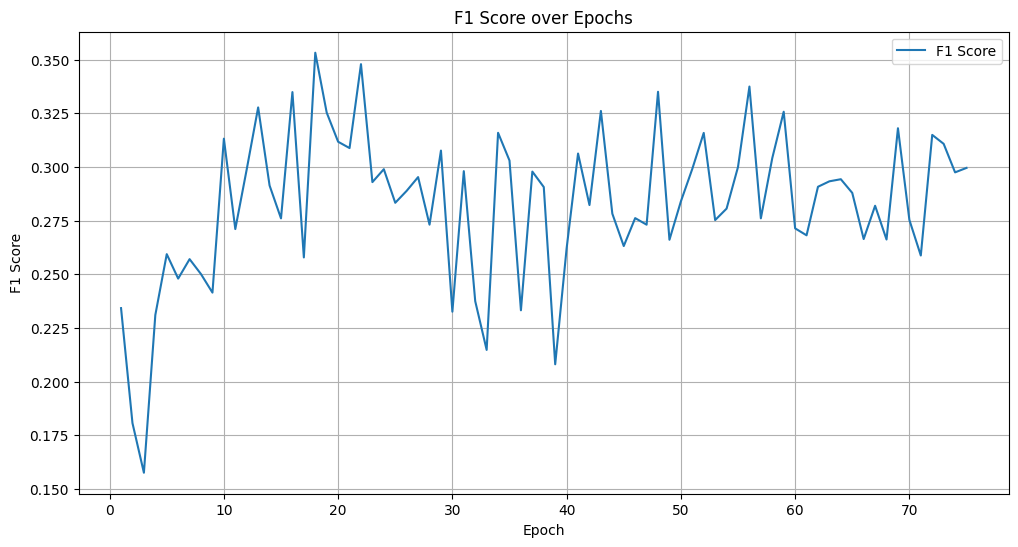

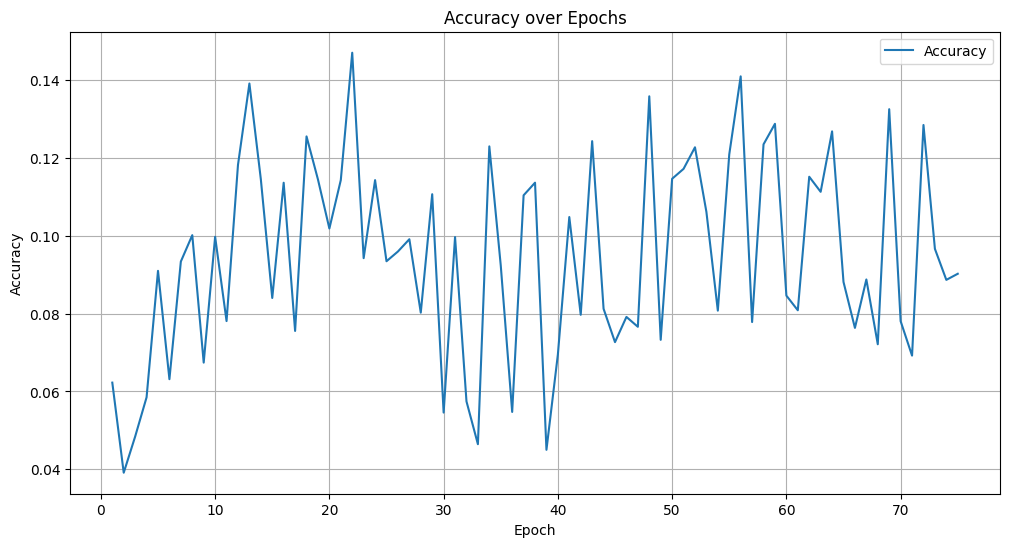

({'Final Precision': 0.32379,
  'Final Recall': 0.27865,
  'Final mAP50': 0.2208,
  'Final mAP50-95': 0.16378,
  'Final F1 Score': 0.2995288609654073,
  'Final Accuracy': 0.09022408350000001},
 {'Best Epoch': 18.0,
  'Best Precision': 0.38362,
  'Best Recall': 0.32719,
  'Best mAP50': 0.18877,
  'Best mAP50-95': 0.12412,
  'Best F1 Score': 0.3531650590171776,
  'Best Accuracy': 0.1255166278,
  'Train Box Loss': 1.1127,
  'Train Class Loss': 1.6748,
  'Train DFL Loss': 1.1457,
  'Validation Box Loss': 1.3175,
  'Validation Class Loss': 2.3517,
  'Validation DFL Loss': 1.2829})

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the results.csv file from the specified directory
results_csv_path = r'C:\Users\Nicho\Desktop\Thesis\yodaTaco2\results.csv'
results_df = pd.read_csv(results_csv_path)

# Clean column names by stripping leading and trailing spaces
results_df.columns = results_df.columns.str.strip()

# Calculate the F1 score for each epoch
results_df['f1_score'] = 2 * (results_df['metrics/precision(B)'] * results_df['metrics/recall(B)']) / (results_df['metrics/precision(B)'] + results_df['metrics/recall(B)'])

# Calculate the accuracy for each epoch
results_df['accuracy'] = results_df['metrics/precision(B)'] * results_df['metrics/recall(B)']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['epoch'], results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['epoch'], results_df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(results_df['epoch'], results_df['val/box_loss'], label='Validation Box Loss')
plt.plot(results_df['epoch'], results_df['val/cls_loss'], label='Validation Class Loss')
plt.plot(results_df['epoch'], results_df['val/dfl_loss'], label='Validation DFL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot precision over epochs
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['metrics/precision(B)'], label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot recall over epochs
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['metrics/recall(B)'], label='Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot mAP over epochs
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['metrics/mAP50(B)'], label='mAP50')
plt.plot(results_df['epoch'], results_df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 score over epochs
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['f1_score'], label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(results_df['epoch'], results_df['accuracy'], label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Summarize the final values for precision, recall, mAP, F1 score, and accuracy
final_epoch = results_df.iloc[-1]
summary_metrics = {
    'Final Precision': final_epoch['metrics/precision(B)'],
    'Final Recall': final_epoch['metrics/recall(B)'],
    'Final mAP50': final_epoch['metrics/mAP50(B)'],
    'Final mAP50-95': final_epoch['metrics/mAP50-95(B)'],
    'Final F1 Score': final_epoch['f1_score'],
    'Final Accuracy': final_epoch['accuracy']
}

# Find the best epoch based on F1 score
best_epoch_idx = results_df['f1_score'].idxmax()
best_epoch = results_df.iloc[best_epoch_idx]
best_epoch_details = {
    'Best Epoch': best_epoch['epoch'],
    'Best Precision': best_epoch['metrics/precision(B)'],
    'Best Recall': best_epoch['metrics/recall(B)'],
    'Best mAP50': best_epoch['metrics/mAP50(B)'],
    'Best mAP50-95': best_epoch['metrics/mAP50-95(B)'],
    'Best F1 Score': best_epoch['f1_score'],
    'Best Accuracy': best_epoch['accuracy'],
    'Train Box Loss': best_epoch['train/box_loss'],
    'Train Class Loss': best_epoch['train/cls_loss'],
    'Train DFL Loss': best_epoch['train/dfl_loss'],
    'Validation Box Loss': best_epoch['val/box_loss'],
    'Validation Class Loss': best_epoch['val/cls_loss'],
    'Validation DFL Loss': best_epoch['val/dfl_loss']
}

summary_metrics, best_epoch_details


Implement the User Interface Functions

In [1]:
import os
import json
import torch
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import filedialog
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Initialize YOLO model with the 'best' weights from the specified directory
model_path = 'C:/Users/Nicho/Desktop/Thesis/yodaTaco2/litter-detection-env/runs/detect/train9/weights/best.pt'
model = YOLO(model_path)

# Ensure the model runs on CPU
device = 'cpu'
model.to(device)

# Updated class names based on the custom_data.yaml file
class_names = ['plastic', 'metal', 'glass', 'paper', 'other']

# main window
root = tk.Tk()
root.title("Waste Detection Interface")
root.geometry("800x600")

# class names in a new window
def show_class_names():
    class_window = tk.Toplevel(root)
    class_window.title("Detection Options")
    class_window.geometry("300x400")
    tk.Label(class_window, text="Detection Classes", font=("Helvetica", 16)).pack(pady=10)
    for idx, class_name in enumerate(class_names):
        tk.Label(class_window, text=f"{idx + 1}. {class_name}").pack()

# image detection
def image_detection():
    def open_image():
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
        if file_path:
            image = Image.open(file_path)
            results = model.predict(source=image, device=device, conf=0.25, save_txt=False, save_conf=False, classes=range(len(class_names)))

            # Display image with bounding boxes
            result_img = results[0].plot()
            result_img = Image.fromarray(result_img)
            result_img = result_img.resize((500, 500), Image.LANCZOS)
            img_tk = ImageTk.PhotoImage(result_img)

            panel.config(image=img_tk)
            panel.image = img_tk

    clear_screen()
    tk.Label(root, text="Image Detection", font=("Helvetica", 16)).pack()
    tk.Button(root, text="Select Image", command=open_image).pack()
    tk.Button(root, text="Home", command=home_screen).pack()
    global panel
    panel = tk.Label(root)
    panel.pack()

# video detection
def video_detection():
    def open_video():
        file_path = filedialog.askopenfilename(filetypes=[("Video files", "*.mp4 *.avi *.mov")])
        if file_path:
            cap = cv2.VideoCapture(file_path)
            while(cap.isOpened()):
                ret, frame = cap.read()
                if not ret:
                    break
                results = model.predict(source=frame, device=device, conf=0.25, save_txt=False, save_conf=False, classes=range(len(class_names)))
                frame = results[0].plot()
                cv2.imshow('Video Detection', frame)
                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
            cap.release()
            cv2.destroyAllWindows()
    
    clear_screen()
    tk.Label(root, text="Video Detection", font=("Helvetica", 16)).pack()
    tk.Button(root, text="Select Video", command=open_video).pack()
    tk.Button(root, text="Home", command=home_screen).pack()

# live feed detection
def live_feed_detection():
    def start_live_feed():
        cap = cv2.VideoCapture(0)  
        while(True):
            ret, frame = cap.read()
            if not ret:
                break
            results = model.predict(source=frame, device=device, conf=0.25, save_txt=False, save_conf=False, classes=range(len(class_names)))
            frame = results[0].plot()
            cv2.imshow('Live Feed Detection', frame)
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

    clear_screen()
    tk.Label(root, text="Live Feed Detection", font=("Helvetica", 16)).pack()
    tk.Button(root, text="Start Live Feed", command=start_live_feed).pack()
    tk.Button(root, text="Home", command=home_screen).pack()

# clear  screen
def clear_screen():
    for widget in root.winfo_children():
        widget.destroy()

# home screen
def home_screen():
    clear_screen()
    tk.Label(root, text="Waste Detection Interface", font=("Helvetica", 20)).pack(pady=20)
    tk.Button(root, text="Image Detection", command=image_detection, width=20, height=2).pack(pady=10)
    tk.Button(root, text="Video Detection", command=video_detection, width=20, height=2).pack(pady=10)
    tk.Button(root, text="Live Feed Detection", command=live_feed_detection, width=20, height=2).pack(pady=10)
    tk.Button(root, text="Show Detection Classes", command=show_class_names, width=20, height=2).pack(pady=10)

home_screen()

root.mainloop()



0: 480x640 1 plastic, 4 metals, 1 paper, 63.4ms
Speed: 2.8ms preprocess, 63.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 plastic, 4 metals, 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 plastics, 4 metals, 1 glass, 2 papers, 57.9ms
Speed: 1.5ms preprocess, 57.9ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 plastic, 4 metals, 1 paper, 58.1ms
Speed: 1.0ms preprocess, 58.1ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 4 metals, 1 paper, 58.5ms
Speed: 1.0ms preprocess, 58.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 plastic, 4 metals, 1 glass, 1 paper, 57.3ms
Speed: 1.5ms preprocess, 57.3ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 plastic, 3 metals, 2 papers, 55.6ms
Speed: 1.5ms preprocess, 55.6ms inference, 1.0ms postprocess per image at 

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\Nicho\anaconda3\Lib\tkinter\__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\Nicho\AppData\Local\Temp\ipykernel_88740\1061389802.py", line 95, in start_live_feed
    if cv2.waitKey(25) & 0xFF == ord('q'):
       ^^^^^^^^^^^^^^^
KeyboardInterrupt
